In [11]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import seaborn as sns

###########################################################################
####### IF THE SHAPE FILE ALREADY EXISTS THEN RUN THE FOLLOWING############
###########################################################################

caBaseMap = gpd.read_file("/Users/andrewchang/Desktop/222/tmp/CA_Counties/CA_Counties_TIGER2016.shp")
crs = "+proj=longlat +datum=WGS84 +no_defs"####Scale the crs
ca = caBaseMap.to_crs(crs=crs) # this is for plotting without basemape

with open('/Users/andrewchang/Desktop/222/data/latest_data.json', "r") as latest:
    data = json.load(latest)
data = gpd.GeoDataFrame.from_features(data["features"]) 
data.crs={'init': 'epsg:3857'} # assign crs

###########################################################################
############################    DATA WRANGLING    #########################
###########################################################################
latest = data[data.OutageType == "Not Planned"].copy()
latest = latest.drop(['EstimatedRestoreDate','Cause', 'OutageStatus', 'OutageType', 'GlobalID', 'OutageTypeColor','OutageStatusColor', 'IncidentId'],axis = 1)

scaler = MinMaxScaler()

# extract longtitude and lattitude, then scale it to [0,1] range
latest['x'] = scaler.fit_transform(latest.geometry.centroid.x.values.reshape(-1,1))
latest['y'] = scaler.fit_transform(latest.geometry.centroid.y.values.reshape(-1,1))

# process datetime data
latest.StartDate = pd.to_datetime(latest.StartDate, format='%Y-%m-%dT%H:%M:%S.%fZ')
latest.rename(columns={"StartDate":"StartDateTime"}, inplace = True)
latest['StartDate'] = latest.StartDateTime.dt.date
latest['StartTime'] = latest.StartDateTime.dt.time
latest = latest.sort_values(by = "StartDate", ascending = True)

# add a column to show the power outage density for each county
caBaseMap["NAME"]=caBaseMap.NAME.str.upper()
caBaseMap["Count"] = caBaseMap.NAME.map(latest.County.value_counts())
caBaseMap["Count"].fillna(0, inplace = True)
###########################################################################
###################    DATA VISUALIZATIONS/ANALYSIS   #####################
###########################################################################
import mplleaflet as mpll
fig,ax = plt.subplots(figsize = (30,15))
latest.plot(ax = ax, color = "red")

mpll.display(fig, crs= latest.crs)


/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


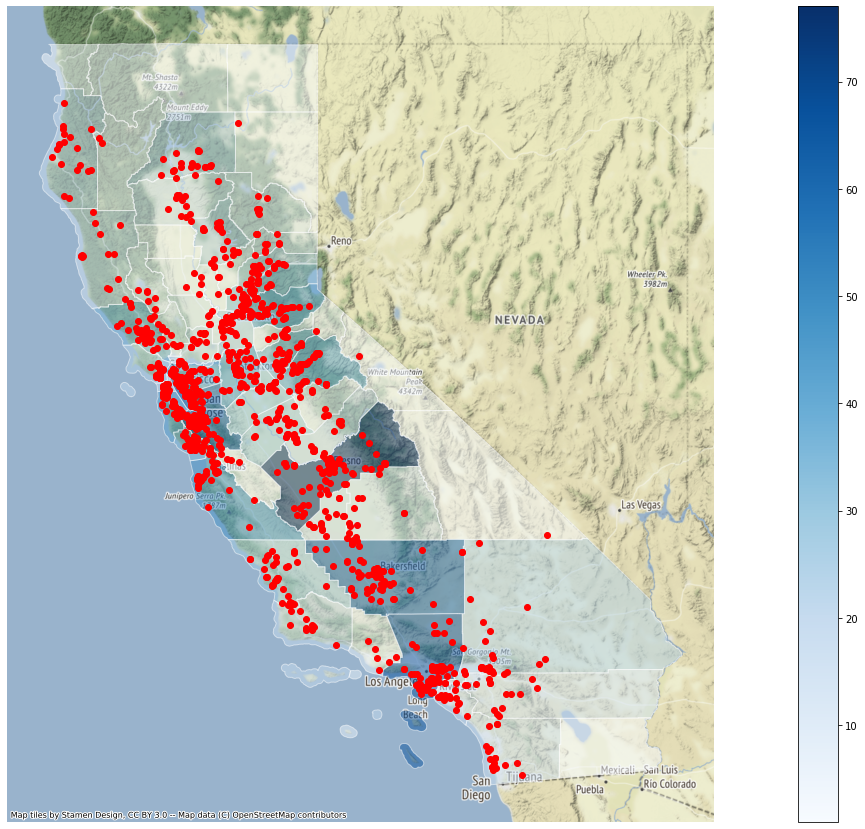

In [12]:
fig,ax = plt.subplots(figsize = (30,15))
caBaseMap.plot(ax=ax, alpha=0.5, edgecolor='1', column = "Count", cmap='Blues')
latest.plot(ax = ax, color = "red")
ctx.add_basemap(ax) # url=ctx.sources. can be added to change the background
ax.set_axis_off()
# Create colorbar as a legend
 vmax, vmin = caBaseMap["Count"].max(),caBaseMap["Count"].min()
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
plt.show()

NotImplementedError: 